In [172]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")

In [173]:
RAW_PFG_DATA_FOLDER = r'..\data\raw\persuasion_for_good'

def load_pfg_data(annotated=False):
    '''
    Load the persuasion for good data
    :param annotated: If True, load the annotated data. If False, load the full data
    :return: A tuple of two dataframes. The first dataframe contains the dialog data, and the second dataframe contains the info data
    '''

    # Load the data
    if annotated:
        dialog_file = os.path.join(RAW_PFG_DATA_FOLDER, '300_dialog.csv')
        info_file = os.path.join(RAW_PFG_DATA_FOLDER, '300_info.csv')
    else:
        dialog_file = os.path.join(RAW_PFG_DATA_FOLDER, 'full_dialog.csv')
        info_file = os.path.join(RAW_PFG_DATA_FOLDER, 'full_info.csv')

    dialog_data = pd.read_csv(dialog_file)
    info_data = pd.read_csv(info_file)
    return dialog_data, info_data

dialog_data, info_data = load_pfg_data()

### Value in Column 'B6' will be considered as the persuasion metric that we are trying to predict

#### Data Cleaning

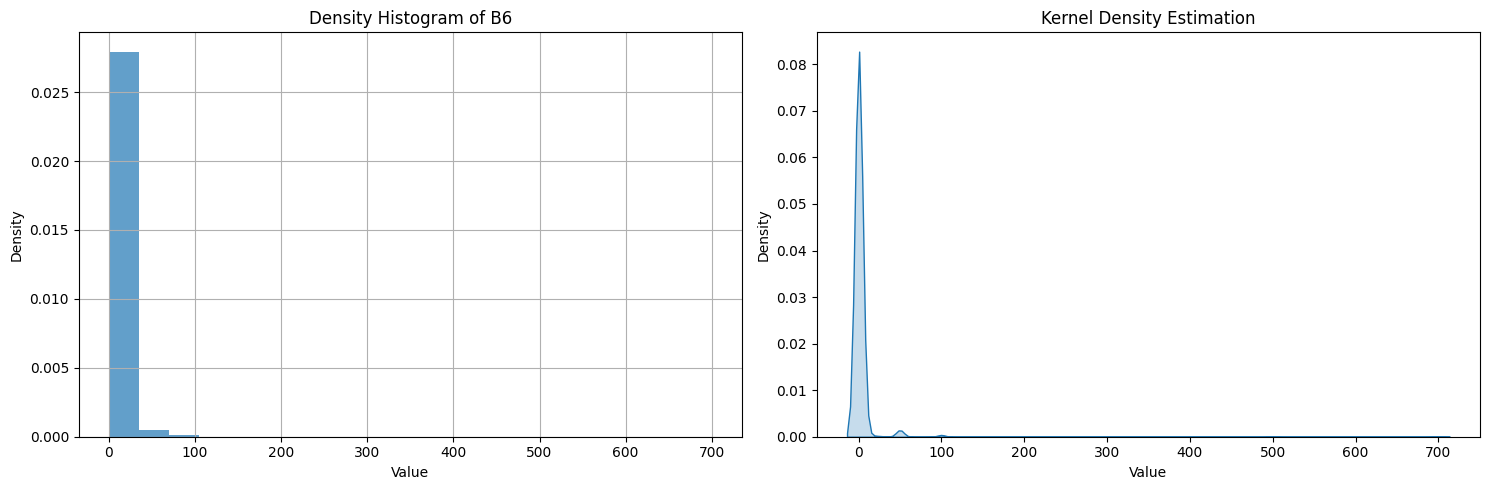

In [174]:
def plot_percentage_histogram(df, col, bins=10):
    """
    Plots a percentage distribution histogram for a specified numeric column in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    col (str): The name of the column to plot.
    bins (int): The number of bins for the histogram. Default is 10.
    """
    if col not in df.columns:
        raise ValueError(f"Column '{col}' does not exist in the DataFrame.")

    plt.figure(figsize=(15,5))

    # Histogram Density Subplot
    plt.subplot(121)
    df[col].hist(bins=20, density=True, alpha=0.7)
    plt.title('Density Histogram of {tile}'.format(tile=col))
    plt.xlabel('Value')
    plt.ylabel('Density')

    # KDE Subplot 
    plt.subplot(122)
    sns.kdeplot(df[col], fill=True)
    plt.title('Kernel Density Estimation')
    plt.xlabel('Value')
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

# Plot the percentage distribution of column 'B6' in the info data
plot_percentage_histogram(info_data, 'B6', bins=20)

As the maximum amount that a user can donate finally cannot exceed more than 2 dollars. The data should be cleaned to get rid of these rows.

In [175]:
invalid_records = info_data[info_data['B6'] > 2]
print(f"Number of records with 'B6' greater than 2: {invalid_records.shape[0]} ({invalid_records.shape[0]/info_data.shape[0]*100:.2f}%)")
### 3.69% of the data has a value greater than 2 which needs to be removed

# Remove rows where 'B6' is greater than 2
info_data = info_data[info_data['B6'] <= 2]
print(f"Number of records after removing rows with 'B6' greater than 2: {info_data.shape[0]}")

Number of records with 'B6' greater than 2: 75 (3.69%)
Number of records after removing rows with 'B6' greater than 2: 1959


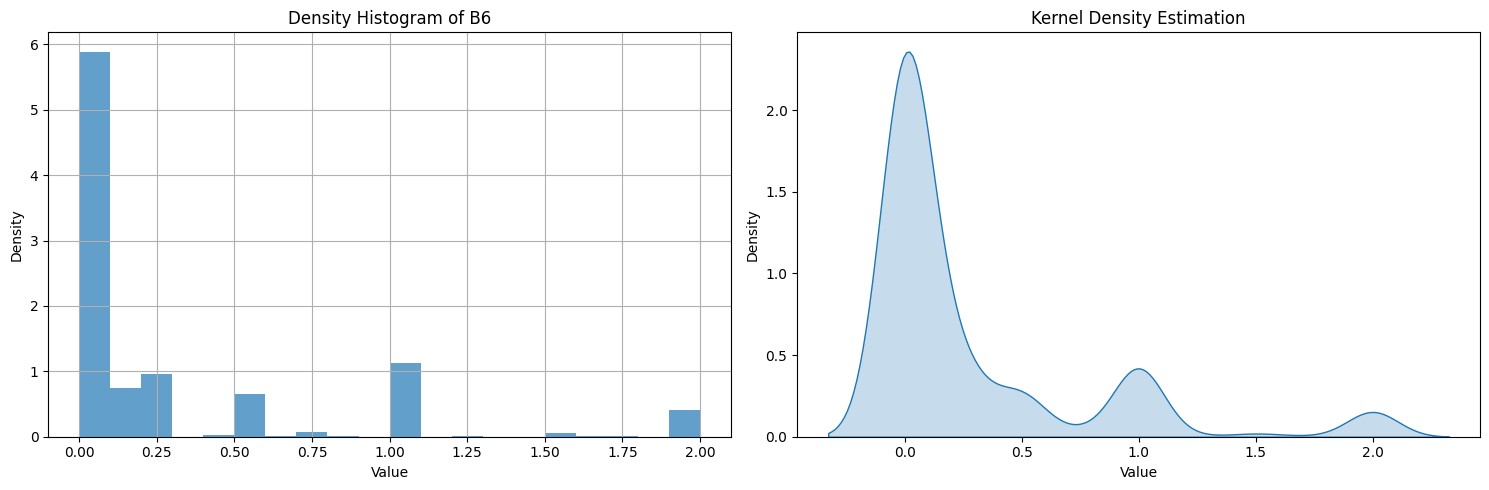

In [176]:
plot_percentage_histogram(info_data, 'B6', bins=20)

#### Persuadee's value will only be considered as it is only considered as representation of persuasion metric

In [177]:
# Remove persuader data for now to get the persuasion data
info_data = info_data[info_data['B4'] != 0]
print(f"Number of records after removing persuader data: {info_data.shape[0]}")

Number of records after removing persuader data: 982


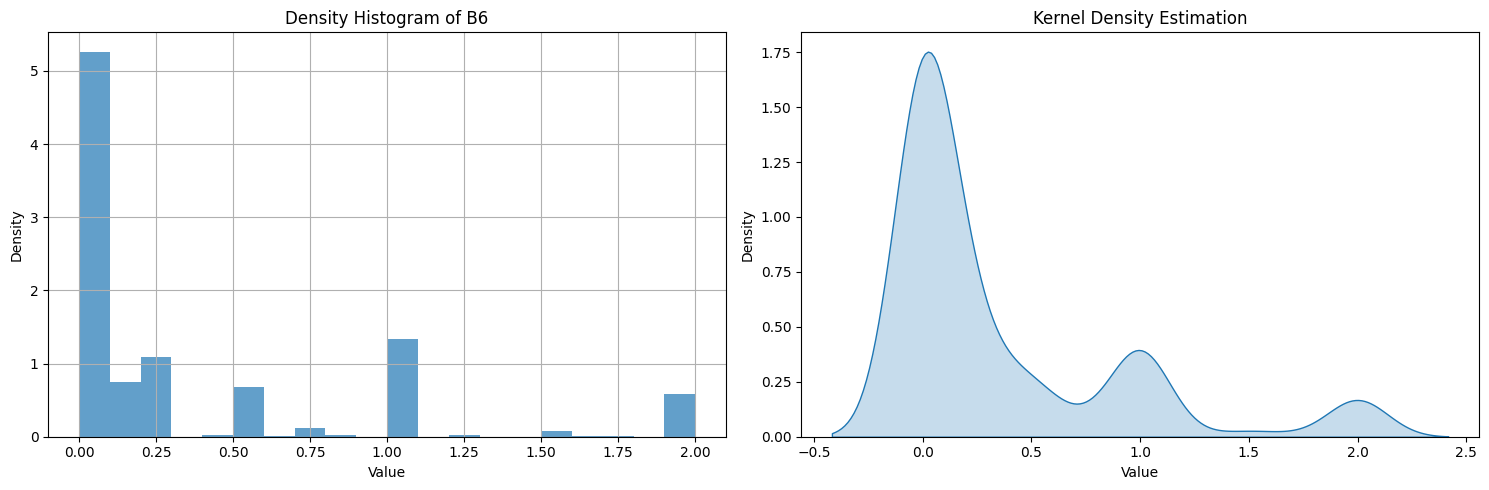

In [178]:
# Plot the percentage distribution of column 'B6' in the info data
plot_percentage_histogram(info_data, 'B6', bins=20)

So there is no difference in the distribution by removing the persuader information

In [179]:
info_data.isna().sum()

B2                  0
B3                  0
B4                  0
B6                  0
B7                  0
extrovert.x         5
agreeable.x         5
conscientious.x     5
neurotic.x          5
open.x              5
care.x              5
fairness.x          5
loyalty.x           5
authority.x         5
purity.x            5
freedom.x           5
conform.x           5
tradition.x         5
benevolence.x       5
universalism.x      5
self_direction.x    5
stimulation.x       5
hedonism.x          5
achievement.x       5
power.x             5
security.x          5
rational.x          5
intuitive.x         5
age.x               6
sex.x               6
race.x              6
edu.x               6
marital.x           6
employment.x        6
income.x            6
religion.x          6
ideology.x          6
dtype: int64

We may have missing demographic information, let us try 
- Skipping these records
- Fill with mean/median for the predictability

In [180]:
df = info_data.dropna(axis=0, how='any')

In [181]:
print(f"Number of records after removing rows with missing values: {df.shape[0]}")

Number of records after removing rows with missing values: 975


In [182]:
df

,B2,B3,B4,B6,B7,extrovert.x,agreeable.x,conscientious.x,neurotic.x,open.x,...,intuitive.x,age.x,sex.x,race.x,edu.x,marital.x,employment.x,income.x,religion.x,ideology.x
1,20180904-045349_715_live,user_1810,1,0.00,11,3.2,4.0,3.8,2.0,3.2,...,4.0,50.0,Female,White,Less than four-year college,Married,Employed for wages,10.0,Protestant,Conservative
3,20180904-154250_98_live,user_2234,1,2.00,10,3.0,3.6,3.2,3.0,3.0,...,2.0,30.0,Male,White,Less than four-year college,Unmarried,Employed for wages,2.0,Atheist,Liberal
5,20180904-024226_703_live,user_1153,1,0.05,10,2.8,3.4,3.8,3.0,5.0,...,4.5,28.0,Male,White,Less than four-year college,Married,Other,4.0,Atheist,Moderate
7,20180904-100019_870_live,user_1879,1,0.00,11,3.8,4.8,4.8,1.2,4.4,...,4.0,42.0,Male,White,Four-year college,Married,Employed for wages,9.0,Catholic,Conservative
9,20180904-001208_706_live,user_527,1,1.00,11,2.4,3.0,4.2,1.2,3.6,...,4.0,32.0,Male,Other,Less than four-year college,Married,Employed for wages,9.0,Other religion,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,20180827-004200_630_live,user_1753,1,0.30,11,3.2,4.8,5.0,1.6,4.8,...,4.0,53.0,Female,White,Four-year college,Married,Other,3.0,Other religion,Liberal
2023,20180827-050542_196_live,user_1693,1,0.00,10,5.0,5.0,4.6,1.0,5.0,...,2.0,36.0,Male,White,Four-year college,Married,Employed for wages,11.0,Other religion,Liberal
2027,20180827-051947_34_live,user_678,1,0.00,10,3.2,3.4,3.2,3.2,2.6,...,3.0,38.0,Male,White,Postgraduate,Married,Employed for wages,11.0,Other religion,Moderate
2029,20180827-034916_910_live,user_1758,1,0.30,10,3.8,4.8,4.0,2.4,4.2,...,3.0,53.0,Female,White,Less than four-year college,Married,Employed for wages,8.0,Catholic,Liberal


#### Convert non-numeric datatypes into numerical columns

In [183]:
non_numeric_cols = df.select_dtypes(exclude='number').columns.to_list()

skip_cols = ["B2", "B3"] # These columns are not relevant for the analysis
categ_cols = ["sex.x", "race.x", "edu.x", "marital.x", "employment.x", "religion.x", "ideology.x"]

# Convert categorical columns to numeric using categorical encoder
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoded_categ_cols = pd.DataFrame(encoder.fit_transform(df[categ_cols]), columns=encoder.get_feature_names_out(categ_cols))

# Drop original categorical columns and concatenate the encoded columns
df = df.drop(columns=categ_cols).reset_index(drop=True)
df = pd.concat([df, encoded_categ_cols], axis=1)

df.head(5)

,B2,B3,B4,B6,B7,extrovert.x,agreeable.x,conscientious.x,neurotic.x,open.x,...,marital.x_Unmarried,employment.x_Employed for wages,employment.x_Other,religion.x_Atheist,religion.x_Catholic,religion.x_Other religion,religion.x_Protestant,ideology.x_Conservative,ideology.x_Liberal,ideology.x_Moderate
0,20180904-045349_715_live,user_1810,1,0.00,11,3.2,4.0,3.8,2.0,3.2,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,20180904-154250_98_live,user_2234,1,2.00,10,3.0,3.6,3.2,3.0,3.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,20180904-024226_703_live,user_1153,1,0.05,10,2.8,3.4,3.8,3.0,5.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,20180904-100019_870_live,user_1879,1,0.00,11,3.8,4.8,4.8,1.2,4.4,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,20180904-001208_706_live,user_527,1,1.00,11,2.4,3.0,4.2,1.2,3.6,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


#### Scaling numerical features

In [184]:
# SCALING
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include='number').columns.to_list()
numeric_cols.remove('B6') # Skip the target column

# Scale the numeric columns
scaled_numeric_cols = pd.DataFrame(scaler.fit_transform(df[numeric_cols]), columns=numeric_cols)

# Drop original numeric columns and concatenate the scaled columns
df = df.drop(columns=numeric_cols).reset_index(drop=True)
df = pd.concat([df, scaled_numeric_cols], axis=1)

df.head(5)

,B2,B3,B6,B4,B7,extrovert.x,agreeable.x,conscientious.x,neurotic.x,open.x,...,marital.x_Unmarried,employment.x_Employed for wages,employment.x_Other,religion.x_Atheist,religion.x_Catholic,religion.x_Other religion,religion.x_Protestant,ideology.x_Conservative,ideology.x_Liberal,ideology.x_Moderate
0,20180904-045349_715_live,user_1810,0.00,0.0,0.812300,0.000220,0.064287,-0.147021,-0.571532,-0.682928,...,-1.019681,0.726783,-0.726783,-0.407760,-0.495188,-0.793999,1.6284,1.482134,-0.823493,-0.628371
1,20180904-154250_98_live,user_2234,2.00,0.0,-0.619874,-0.213957,-0.405224,-0.950826,0.442376,-0.971677,...,0.980699,0.726783,-0.726783,2.452425,-0.495188,-0.793999,-0.6141,-0.674703,1.214339,-0.628371
2,20180904-024226_703_live,user_1153,0.05,0.0,-0.619874,-0.428133,-0.639979,-0.147021,0.442376,1.915813,...,-1.019681,-1.375927,1.375927,2.452425,-0.495188,-0.793999,-0.6141,-0.674703,-0.823493,1.591417
3,20180904-100019_870_live,user_1879,0.00,0.0,0.812300,0.642749,1.003308,1.192654,-1.382659,1.049566,...,-1.019681,0.726783,-0.726783,-0.407760,2.019437,-0.793999,-0.6141,1.482134,-0.823493,-0.628371
4,20180904-001208_706_live,user_527,1.00,0.0,0.812300,-0.856486,-1.109489,0.388849,-1.382659,-0.105430,...,-1.019681,0.726783,-0.726783,-0.407760,-0.495188,1.259447,-0.6141,-0.674703,-0.823493,1.591417


### Model development

`Target Column`
- B6 : Donation amount column

`Drop the columns`
- B2 : Just chat identifier
- B3 : User identifier
- B4 : User type identifier (going to be 1 as we are interested in persuadee's only)

R2 Score: 0.04
Train Mean Squared Error: 0.27011582900493697 Validation Mean Squared Error: 0.3067195608338252


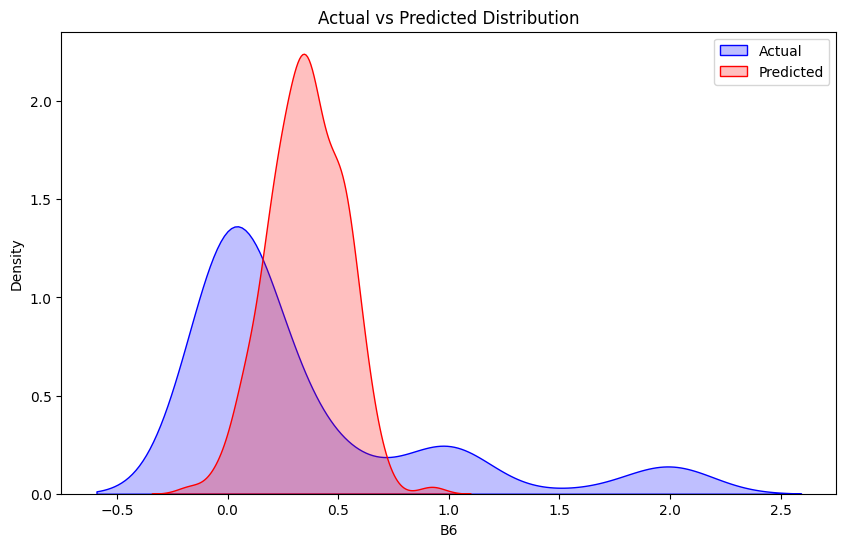

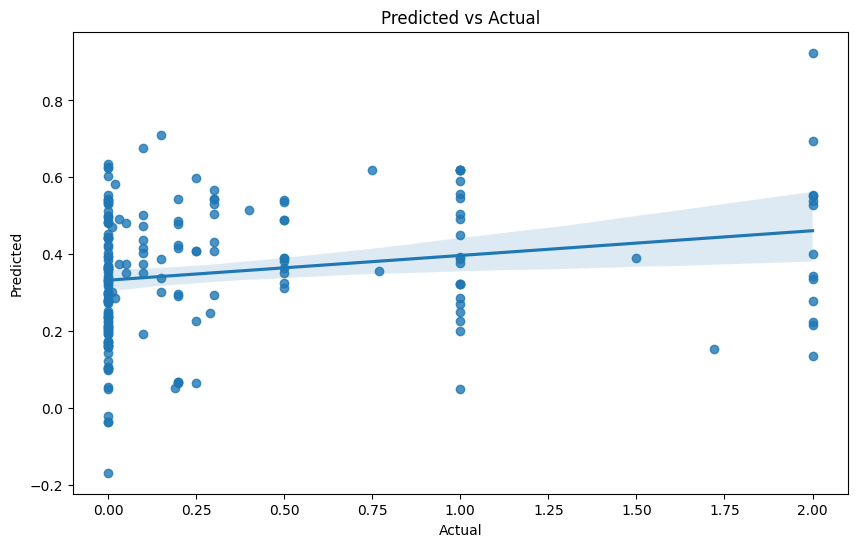

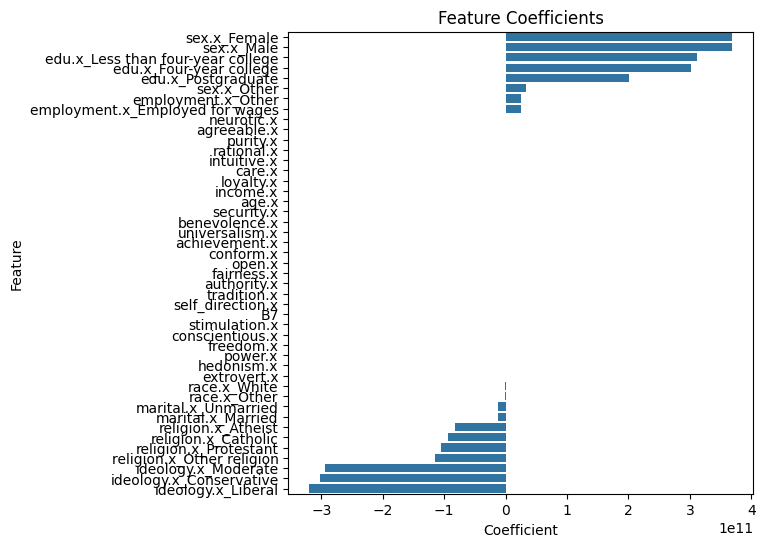

In [185]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Define the target column and columns to drop
target = 'B6'
drop_cols = ['B2', 'B3', 'B4']


def build_evaluate_lr_model(data_df: pd.DataFrame, drop_cols: list, target: str, plot:bool = True, print_output:bool = False) -> float:
    """
    Builds and evaluates a linear regression model using the specified data.

    Parameters:
    data_df (pd.DataFrame): The DataFrame containing the data.
    drop_cols (list): A list of columns to drop from the data before training the model.
    target (str): The target column for the regression model.

    Returns:
    float: The R^2 score of the model.
    """

    # Prepare the data for training
    X = data_df.drop(columns=drop_cols + [target])
    y = data_df[target]

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build a pipeline
    model = LinearRegression()

    model.fit(X_train, y_train)

    # Evaluate the model
    r2_score = model.score(X_val, y_val)
    if print_output:
        print(f"R2 Score: {r2_score:.02f}")

    # Calculate the mean squared error
    y_train_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    if print_output:
        print(f"Train Mean Squared Error: {mse}", end=" ")

    # Calculate the mean squared error
    y_val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    if print_output:
        print(f"Validation Mean Squared Error: {mse}")
    
    # Get the feature coefficients
    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_
    })

    if plot:
        # Sort the coefficients by absolute value
        # coef_df['Coefficient'] = coef_df['Coefficient'].abs()
        coef_df = coef_df.sort_values('Coefficient', ascending=False)

        # Distribution of the validation predictions and actual values
        plt.figure(figsize=(10, 6))
        sns.kdeplot(y_val, color='b', label='Actual', fill=True)
        sns.kdeplot(y_val_pred, color='r', label='Predicted', fill=True)
        plt.xlabel('B6')
        plt.ylabel('Density')
        plt.title('Actual vs Predicted Distribution')
        plt.legend()
        plt.show()

        # Plot the predicted vs actual values along with the line of best fit and residuals
        plt.figure(figsize=(10, 6))
        sns.regplot(x=y_val, y=y_val_pred)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Predicted vs Actual')

        # Plot the distribution of the coefficients as featture importance
        plt.figure(figsize=(6, 6))
        sns.barplot(x='Coefficient', y='Feature', data=coef_df)
        plt.title('Feature Coefficients')
        plt.show()

    return model, r2_score, mse

baseline_lr, r2s, val_mse = build_evaluate_lr_model(df, drop_cols, target, print_output=True, plot=True)

In [186]:
def analyze_corr_threshold(df: pd.DataFrame, print_output: bool = False) -> float:
    """
    Analyzes the correlation between numeric columns in the DataFrame and suggests a threshold for dropping highly correlated columns.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.

    Returns:
    float: The suggested threshold for dropping highly correlated columns.
    """
    # Get the numeric columns
    num_cols = df.select_dtypes(include='number').columns.to_list()
    memory = {}

    for threshold in range(55, 96, 5):
        threshold /= 100
        corr_matrix = df[num_cols].corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

        memory[threshold] = {}
        if print_output:
            print(f"Threshold: {threshold}, # Columns to drop: {len(to_drop)}")
        tmp = df.drop(columns=to_drop)

        # Build and evaluate the linear regression model with the updated data
        updated_lr, updated_r2s, val_mse = build_evaluate_lr_model(tmp, drop_cols, target, plot=False,
                                                                   print_output=print_output)
        if print_output:
            print(f"R2 Score: {updated_r2s:.02f}")
        memory[threshold]['r2_score'] = updated_r2s
        memory[threshold]['to_drop'] = to_drop
        memory[threshold]['model'] = updated_lr
        memory[threshold]['mse'] = val_mse

    # find the threshold with the highest R2 score and lowest validation score, model and columns to drop
    best_threshold = max(memory, key=lambda x: (memory[x]['r2_score'], -memory[x]['mse']))
    to_drop = memory[best_threshold]['to_drop']
    updated_lr = memory[best_threshold]['model']
    val_mse = memory[best_threshold]['mse']
    r2s = memory[best_threshold]['r2_score']

    return best_threshold, to_drop, updated_lr, val_mse, r2s

best_threshold, to_drop, updated_lr, val_mse, r2s = analyze_corr_threshold(df, True)

Threshold: 0.55, # Columns to drop: 14
R2 Score: 0.03
Train Mean Squared Error: 0.2717221819396908 Validation Mean Squared Error: 0.31022173518049256
R2 Score: 0.03
Threshold: 0.6, # Columns to drop: 11
R2 Score: 0.03
Train Mean Squared Error: 0.27287335466563345 Validation Mean Squared Error: 0.309549560268339
R2 Score: 0.03
Threshold: 0.65, # Columns to drop: 10
R2 Score: 0.03
Train Mean Squared Error: 0.27162747237140306 Validation Mean Squared Error: 0.3104460048662266
R2 Score: 0.03
Threshold: 0.7, # Columns to drop: 8
R2 Score: 0.03
Train Mean Squared Error: 0.27130606744308045 Validation Mean Squared Error: 0.3086774123488835
R2 Score: 0.03
Threshold: 0.75, # Columns to drop: 5
R2 Score: 0.04
Train Mean Squared Error: 0.27011832826090165 Validation Mean Squared Error: 0.30670603303085275
R2 Score: 0.04
Threshold: 0.8, # Columns to drop: 4
R2 Score: 0.04
Train Mean Squared Error: 0.2701157649601929 Validation Mean Squared Error: 0.306742828650864
R2 Score: 0.04
Threshold: 0.85, #

In [187]:
print(f"Best Threshold: {best_threshold}")
print(f"Columns to Drop: {to_drop}")
print(f"Validation MSE: {val_mse}")

Best Threshold: 0.75
Columns to Drop: ['sex.x_Male', 'race.x_White', 'edu.x_Less than four-year college', 'marital.x_Unmarried', 'employment.x_Other']
Validation MSE: 0.30670603303085275


#### Clearly the Linear Regression is not performing to capture the distribution, exploring advance models like SVM, Decision Tree, RandomForest, GradientBoost, AdaBoost, XGBoost

In [188]:
# Using the best threshold to drop highly correlated columns, proceed with the updated data
info_data_no_na = df.drop(columns=to_drop, inplace=False)

# Build and evaluate the SVM Regressor, Random Forest Regressor and Gradient Boosting Regressor models with updated data
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

def build_evaluate_model(data_df: pd.DataFrame, drop_cols: list, target: str, model_type: str, plot:bool = False) -> float:
    """
    Builds and evaluates a regression model using the specified data.
    """

    # Prepare the data for training
    X = data_df.drop(columns=drop_cols + [target])
    y = data_df[target]

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    if model_type == 'SVM':
        model = SVR()
    elif model_type == 'RandomForest':
        model = RandomForestRegressor(random_state=42)
    elif model_type == 'GradientBoosting':
        model = GradientBoostingRegressor(random_state=42)
    elif model_type == 'XGBoost':
        model = XGBRegressor(random_state=42)
    elif model_type == 'BaggingRegressor':
        model = BaggingRegressor()
    elif model_type == 'NeuralNetwork':
        model = MLPRegressor(random_state=42)
    else:
        raise ValueError("Invalid model type. Choose from 'SVM', 'RandomForest', 'GradientBoosting'.")

    model.fit(X_train, y_train)

    print(f"Model: {model_type}")

    # Evaluate the model
    r2_score = model.score(X_val, y_val)
    print(f"R2 Score: {r2_score:.02f}")

    # Calculate the mean squared error
    y_train_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    print(f"Train Mean Squared Error: {mse}", end=" ")

    # Calculate the mean squared error
    y_val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    print(f"Validation Mean Squared Error: {mse}")

    if plot:
        # Distribution of the validation predictions and actual values
        plt.figure(figsize=(10, 6))
        sns.kdeplot(y_val, color='b', label='Actual', fill=True)
        sns.kdeplot(y_val_pred, color='r', label='Predicted', fill=True)
        plt.xlabel('B6')
        plt.ylabel('Density')
        plt.title('Actual vs Predicted Distribution')
        plt.legend()
        plt.show()

    return model, r2_score, mse

#### Models exploration

##### SVM

In [189]:
_, _, _ = build_evaluate_model(info_data_no_na, drop_cols, target, 'SVM')

Model: SVM
R2 Score: 0.10
Train Mean Squared Error: 0.13560616024259278 Validation Mean Squared Error: 0.28678919622679344


##### Random Forest

Model: RandomForest
R2 Score: 0.11
Train Mean Squared Error: 0.0505737580678934 Validation Mean Squared Error: 0.2842912697014888


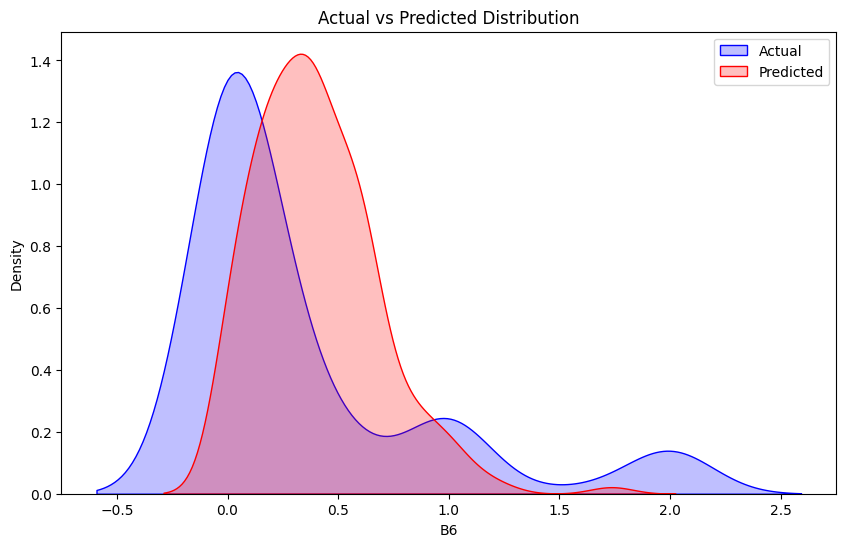

In [190]:
_, _, _ = build_evaluate_model(info_data_no_na, drop_cols, target, 'RandomForest', plot=True)

##### Gradient Boosting

In [191]:
_, _, _ = build_evaluate_model(info_data_no_na, drop_cols, target, 'GradientBoosting')

Model: GradientBoosting
R2 Score: 0.08
Train Mean Squared Error: 0.12100454978277979 Validation Mean Squared Error: 0.2952916178633262


##### XGBoost

Model: XGBoost
R2 Score: 0.11
Train Mean Squared Error: 0.014611939783266664 Validation Mean Squared Error: 0.2845060028327157


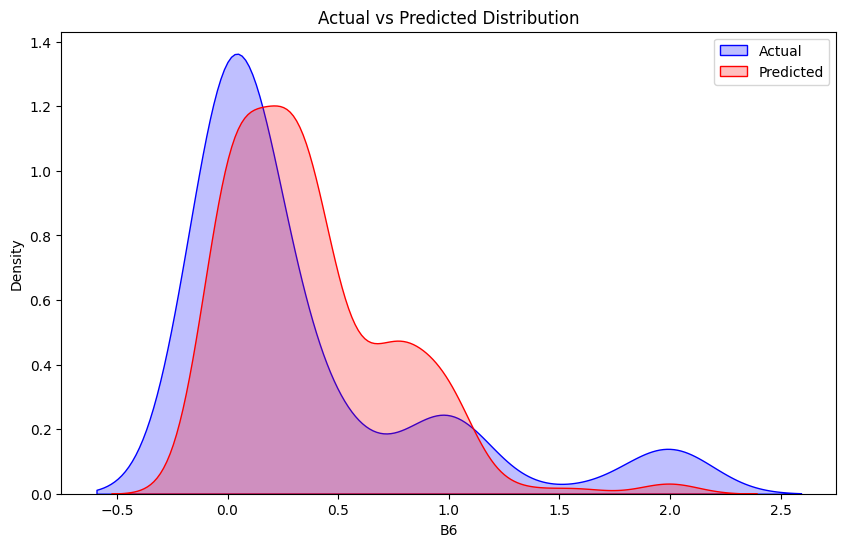

In [192]:
# Fit a XGBoost model
_, _, _ = build_evaluate_model(info_data_no_na, drop_cols, target, 'XGBoost', plot=True)

##### BaggingRegressor

In [193]:
_, _, _ = build_evaluate_model(info_data_no_na, drop_cols, target, 'BaggingRegressor')

Model: BaggingRegressor
R2 Score: 0.01
Train Mean Squared Error: 0.0634659206991845 Validation Mean Squared Error: 0.31478768708326793


##### Neural Network

Model: NeuralNetwork
R2 Score: -0.28
Train Mean Squared Error: 0.019893879091441094 Validation Mean Squared Error: 0.40805460012731487


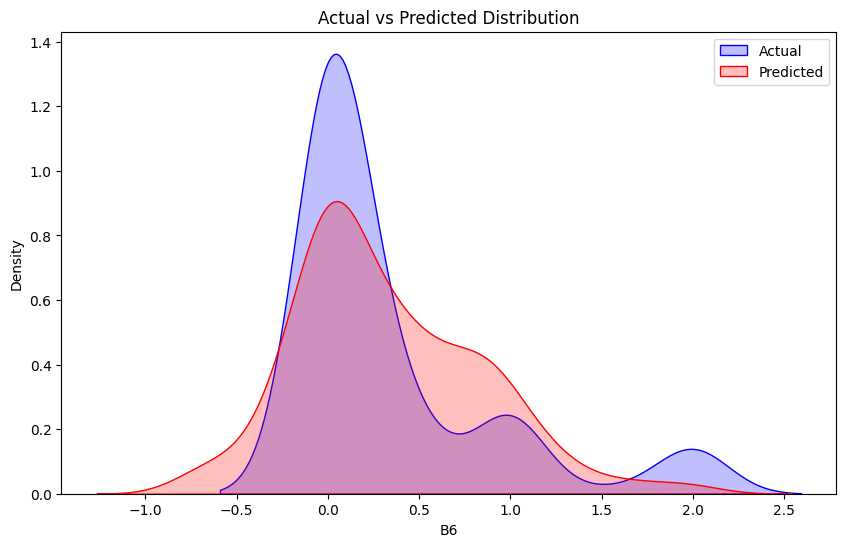

In [194]:
_, _, _ = build_evaluate_model(info_data_no_na, drop_cols, target, 'NeuralNetwork', plot=True)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
R2 Score: 0.09
Train Mean Squared Error: 0.17975787616267838 Validation Mean Squared Error: 0.29156831335597105


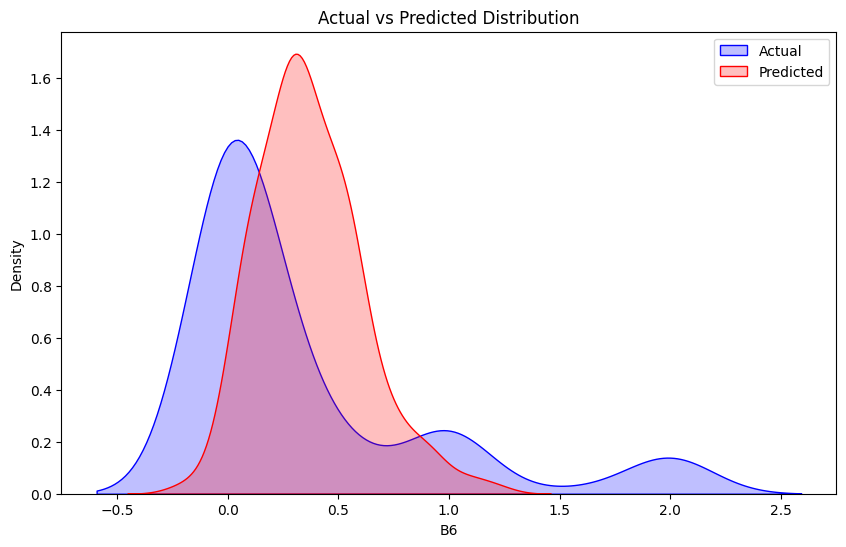

Text(0.5, 1.0, 'Predicted vs Actual')

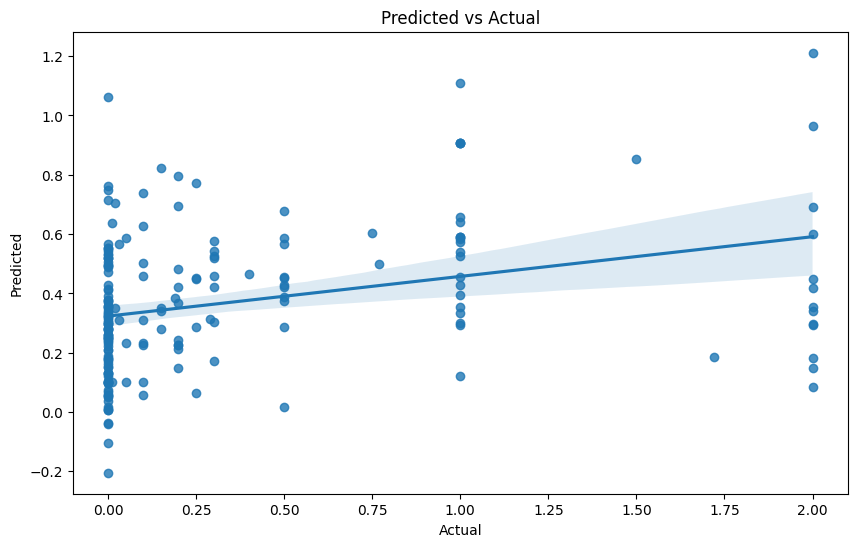

In [195]:
#### Exploring the best model for the neural network as the r2 score is the highest have to lower the mse

# Define the target column and columns to drop
target = 'B6'
drop_cols = ['B2', 'B3', 'B4']

# Prepare the data for training
X = info_data_no_na.drop(columns=drop_cols + [target])
y = info_data_no_na[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a pipeline
model = MLPRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(100,), (300,), (500,), (1000,), (1500,), (2500,)],
    # 'hidden_layer_sizes': [(1500,), (2500,), (4750,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs', "sgd"],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# Perform a grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error',
                           n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model
r2_score = best_model.score(X_val, y_val)
print(f"R2 Score: {r2_score:.02f}")

# Calculate the mean squared error
y_train_pred = best_model.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)

print(f"Train Mean Squared Error: {mse}", end=" ")

# Calculate the mean squared error
y_val_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
print(f"Validation Mean Squared Error: {mse}")

# Distribution of the validation predictions and actual values
plt.figure(figsize=(10, 6))
sns.kdeplot(y_val, color='b', label='Actual', fill=True)
sns.kdeplot(y_val_pred, color='r', label='Predicted', fill=True)
plt.xlabel('B6')
plt.ylabel('Density')
plt.title('Actual vs Predicted Distribution')
plt.legend()
plt.show()

# Plot the predicted vs actual values along with the line of best fit and residuals
plt.figure(figsize=(10, 6))
sns.regplot(x=y_val, y=y_val_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')


In [196]:
# Store the best model into a pickle file
import pickle

with open('best_nn_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Load the best model from the pickle file
with open('best_nn_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Evaluate the loaded model
r2_score = loaded_model.score(X_val, y_val)
print(f"R2 Score: {r2_score:.02f}")

# Calculate the mean squared error
y_train_pred = loaded_model.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
print(f"Train Mean Squared Error: {mse}", end=" ")

# Calculate the mean squared error
y_val_pred = loaded_model.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
print(f"Validation Mean Squared Error: {mse}")

R2 Score: 0.09
Train Mean Squared Error: 0.17975787616267838 Validation Mean Squared Error: 0.29156831335597105
